In [1]:
# Standard Math / Data libraries
import numpy as np
import pandas as pd

# Data Scrape Package
import pandas_datareader.data as web

# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/rnn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set Random seed
import random
random.seed(2505)

In [2]:
# Load the data
df=pd.read_csv('H_data.csv',index_col='Time',parse_dates=True)
df.head(5) 

,Wind speed,Generator speed,Blade angle,Wind direction,Ambient temperature,Active power
Time,,,,,,
2020-01-01 00:00:00,4.925817,10.938283,-0.769883,-337.491817,28.426233,191.225983
2020-01-01 01:00:00,5.592000,12.452083,-0.769833,-332.980200,28.103967,290.682000
2020-01-01 02:00:00,5.129100,11.393017,-0.769883,-334.400667,28.052650,217.358167
2020-01-01 03:00:00,4.320550,10.504867,-0.769733,-337.342867,27.942000,166.289250
2020-01-01 04:00:00,4.401067,10.000917,-0.769833,-352.839817,27.935250,143.285783


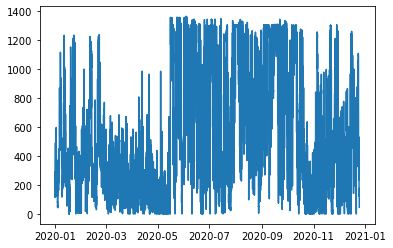

In [3]:
plt.plot(df['Active power'])

In [4]:
returns = df['Active power'].pct_change() # Used for univariate example.

column_names = df.columns
x = df.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df1 = pd.DataFrame(x_scaled)

In [5]:
pct_c_gold = df1

In [6]:
pct_c_gold.columns = column_names

In [7]:
pct_c_gold

,Wind speed,Generator speed,Blade angle,Wind direction,Ambient temperature,Active power
0,0.282462,0.632349,0.333269,0.273920,0.286326,0.139942
1,0.321778,0.719862,0.333269,0.277155,0.262478,0.212725
2,0.294459,0.658637,0.333269,0.276137,0.258680,0.159066
3,0.246742,0.607293,0.333270,0.274027,0.250492,0.121693
4,0.251494,0.578159,0.333269,0.262916,0.249993,0.104859
...,...,...,...,...,...,...
8534,0.274239,0.612551,0.333080,0.548638,0.271718,0.127774
8535,0.267505,0.605733,0.333080,0.558833,0.246149,0.123879
8536,0.274961,0.615699,0.333079,0.569526,0.247543,0.129051
8537,0.206774,0.534451,0.333080,0.580206,0.235903,0.062594


In [8]:
returns

Time
2020-01-01 00:00:00         NaN
2020-01-01 01:00:00    0.520097
2020-01-01 02:00:00   -0.252248
2020-01-01 03:00:00   -0.234953
2020-01-01 04:00:00   -0.138334
                         ...   
2020-12-24 14:00:00    0.438542
2020-12-24 15:00:00   -0.030484
2020-12-24 16:00:00    0.041751
2020-12-24 17:00:00   -0.514969
2020-12-24 18:00:00   -0.460259
Name: Active power, Length: 8539, dtype: float64

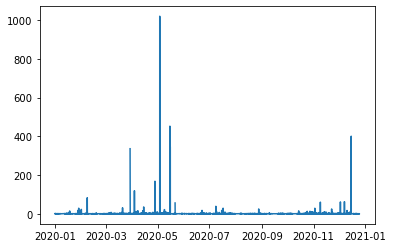

In [9]:
plt.plot(returns)

In [10]:
# Flatten this matrix down.
npa = returns.values[1:].reshape(-1,1) # Python is smart to recognize whatever dimension you need by using this parameter
print(len(npa))
# # Let's scale the data -- this helps avoid the exploding gradient issue
scale = MinMaxScaler(feature_range=(0,1)) # This is by default.
npa = scale.fit_transform(npa)
print(len(npa))

8538


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(npa.shape[0] - samples):
    X.append(npa[i:i+samples]) # Independent Samples
    Y.append(npa[i+samples][0]) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

In [ ]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

threshold = round(0.9 * X.shape[0])
print('Threshold is', threshold)

In [ ]:
# Let's build the RNN
model = keras.Sequential()

# Add a RNN layer with 3 units.
model.add(layers.SimpleRNN(3,
                           activation = 'tanh',
                           use_bias=True,
                           input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

In [ ]:
# Fitting the data
history = model.fit(X[:threshold],
                    Y[:threshold],
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

In [ ]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

In [ ]:
# Predictions using the 'sliding/rolling window approach'
# Multi step forecast.
# Using self predictions for making future predictions

true_Y = Y[threshold:]
pred_Y = []
print('Number of Forecasts to do: ',Y.shape[0] - round(Y.shape[0]*0.9))
latest_input = X[threshold-1:threshold]
for i in range(Y.shape[0] - round(Y.shape[0]*0.9) ):
    # Prediction
    p = model.predict(latest_input.reshape(1,X.shape[1],1))[0,0]
    
    # Update predictions
    pred_Y.append(p)
    latest_input = np.append(X[threshold][1:], p)

In [ ]:
plt.plot(true_Y, label = 'True Value')
plt.plot(pred_Y, label = 'Forecasted Value')
plt.legend()
# Model just copied the same value over and over again. Hence, model is not very robust.
# It's just predicting the mean.

### Multi-Variate Forecasting

In [ ]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(pct_c_gold.shape[0] - samples):
    X.append(pct_c_gold.iloc[i:i+samples, 0:5].values) # Independent Samples
    Y.append(pct_c_gold.iloc[i+samples, 5:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

In [ ]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

In [ ]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

In [ ]:
# Let's build the RNN
model = keras.Sequential()

# Add a RNN layer with 30 internal units.
model.add(layers.SimpleRNN(30,
                           activation = 'tanh',
                           use_bias=True,
                           input_shape=(trainX.shape[1], trainX.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

In [ ]:
# Fitting the data
history = model.fit(trainX,
                    trainY,
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

In [ ]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

In [ ]:
# This is a one step forecast (based on how we constructed our model)
y_pred = model.predict(testX)
plt.plot(testY, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()

In [ ]:
# Predictions using the 'sliding/rolling window approach'
# Multi step forecast.
# Using self predictions for making future predictions
# Very much different from a univariate -- You will need predictions (or known) values for your independent values.
# Nonetheles, you will follow the same steps as shown for the univariate multi-step process.

In [ ]:
len(X[threshold:])

In [ ]:
y_pred

In [ ]:
df0 = pd.DataFrame(y_pred)
df2 = pd.DataFrame(testY)

In [ ]:
from sklearn.metrics import accuracy_score,r2_score,mean_absolute_error, mean_squared_error

print('R2-score:',r2_score(df2, df0))
print('RMSE:',np.sqrt(mean_squared_error(df2, df0)))
print('MAE:',mean_absolute_error(df2, df0))
print('MSE:',mean_squared_error(df2, df0))